# K-Means Clustering with IBM DB2

## Imports

In [1]:
# Database connectivity
import ibm_db
import ibm_db_dbi

# Pandas for loading values into memory for later visualization
import pandas as pd
from IPython.display import display
import numpy as np
# import scipy.stats as ss
from itertools import combinations_with_replacement, combinations

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
%config InlineBackend.figure_format = 'retina'



In [12]:
# Import custom functions
import sys
sys.path.insert(1, '../lib/')
from InDBMLModules import connect_to_schema, drop_object, plot_histogram, close_connection_to_db
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 3. Connect to DB<a class="anchor" id="Connect-to-DB"></a>

In [3]:
# Connect to DB

conn_str = "DATABASE=mydb;" + \
           "HOSTNAME=*****;"+ \
           "PROTOCOL=TCPIP;"  + \
           "PORT=*****;" + \
           "UID=*****;" + \
           "PWD=*****;"

ibm_db_conn = ibm_db.connect(conn_str,"","")
conn = ibm_db_dbi.Connection(ibm_db_conn)
print('Connection to Db2 Instance Created!')
rc = ibm_db.close(ibm_db_conn)

Connection to Db2 Instance Created!


### Create a schema for this demo

In [4]:
ibm_db_conn = ibm_db.connect(conn_str, "", "")
ibm_db_dbi_conn = ibm_db_dbi.Connection(ibm_db_conn)

schema = "CLUSTER"
drop_object("CLUSTER", "SCHEMA", ibm_db_conn, verbose = True)
sql ="create schema CLUSTER authorization MLP"
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print("Schema CLUSTER was created.")

rc = close_connection_to_db(ibm_db_conn, verbose=False)

Pre-existing TABLE CLUSTER.TPCDS_KM_2_COLUMN_STATISTICS was dropped.
Pre-existing TABLE CLUSTER.TPCDS_KM_2_MODEL was dropped.
Pre-existing TABLE CLUSTER.TPCDS_COL_PROP was dropped.
Pre-existing TABLE CLUSTER.TPCDS_KM_2_COLUMNS was dropped.
Pre-existing TABLE CLUSTER.TPCDS_KM_2_CLUSTERS was dropped.
Pre-existing TABLE CLUSTER.TPCDS_KM_2_OUT was dropped.
Pre-existing TABLE CLUSTER.TPCDS_KM_3_COLUMN_STATISTICS was dropped.
Pre-existing TABLE CLUSTER.TPCDS_KM_3_MODEL was dropped.
Pre-existing TABLE CLUSTER.TPCDS_KM_3_COLUMNS was dropped.
Pre-existing TABLE CLUSTER.TPCDS_KM_3_CLUSTERS was dropped.
Pre-existing TABLE CLUSTER.TPCDS_KM_3_OUT was dropped.
Pre-existing TABLE CLUSTER.TPCDS_KM_4_COLUMN_STATISTICS was dropped.
Pre-existing TABLE CLUSTER.TPCDS_KM_4_MODEL was dropped.
Pre-existing TABLE CLUSTER.TPCDS_KM_4_COLUMNS was dropped.
Pre-existing TABLE CLUSTER.TPCDS_KM_4_CLUSTERS was dropped.
Pre-existing TABLE CLUSTER.TPCDS_KM_4_OUT was dropped.
Pre-existing TABLE CLUSTER.TPCDS_KM_5_COLUMN_

## 4. Data Exploration<a class="anchor" id="EDA"></a>

Let's use the IDAX.COLUMN_PROPERTIES stored procedure to collect statistics

In [5]:
ibm_db_conn, conn = connect_to_schema(schema,conn_str)

drop_object("TPCDS_COL_PROP", "TABLE", ibm_db_conn, verbose = True)
sql = "CALL IDAX.COLUMN_PROPERTIES('intable=DATA.TPCDS_50K, outtable=TPCDS_COL_PROP, withstatistics=true,"
sql+= "incolumn=CLIENT_ID:id;NUM_DEPENDANTS:nom;NUM_DEPENDANTS_EMPLOYED:nom;NUM_DEPENDANTS_COUNT:nom;HOUSEHOLD_INCOME:nom ')"
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print("TABLE TPCDS_COL_PROP was created.")

rc = close_connection_to_db(ibm_db_conn, verbose=False)

Pre-existing TABLE TPCDS_COL_PROP was not found.
TABLE TPCDS_COL_PROP was created.


In [6]:
# Identify Columns with missing values
ibm_db_conn, conn = connect_to_schema(schema,conn_str)

sql = "SELECT * FROM TPCDS_COL_PROP"
col_prop = pd.read_sql(sql,conn)

rc = ibm_db.close(ibm_db_conn)

col_prop.sort_values('COLNO')

,COLNO,NAME,SQLTYPE,LENGTH,SCALE,TYPE,ROLE,WEIGHT,CARDINALITY,MINIMUM,MAXIMUM,MEAN,VARIANCE,NUMVALID,NUMINVALID,NUMMISSING
2,0,CLIENT_ID,INTEGER,4,0,cont,id,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,FIRST_NAME,VARCHAR,30,0,nom,input,1.0,3404.0,NaN,NaN,NaN,NaN,49524.0,0.0,476.0
4,2,LAST_NAME,VARCHAR,30,0,nom,input,1.0,4775.0,NaN,NaN,NaN,NaN,49518.0,0.0,482.0
5,3,AGE,DOUBLE,8,0,cont,input,1.0,69.0,28.0,96.0,61.95896,3.965058e+02,49537.0,0.0,463.0
0,4,GENDER,VARCHAR,5,0,nom,input,1.0,2.0,NaN,NaN,NaN,NaN,50000.0,0.0,0.0
12,5,MARITAL_STATUS,VARCHAR,5,0,nom,input,1.0,5.0,NaN,NaN,NaN,NaN,50000.0,0.0,0.0
13,6,EDUCATION,VARCHAR,20,0,nom,input,1.0,7.0,NaN,NaN,NaN,NaN,50000.0,0.0,0.0
14,7,PURCHASE_ESTIMATE,DOUBLE,8,0,cont,input,1.0,20.0,500.0,10000.0,5265.52000,8.285879e+06,50000.0,0.0,0.0
6,8,CREDIT_RATING,VARCHAR,20,0,nom,input,1.0,4.0,NaN,NaN,NaN,NaN,50000.0,0.0,0.0
7,9,NUM_DEPENDANTS,INTEGER,4,0,nom,input,1.0,7.0,NaN,NaN,NaN,NaN,50000.0,0.0,0.0


**Observation**:
- FIRST_NAME and LAST_NAME can be dropped - they have too many unique values (high cardinality)

In [7]:
# Identify Columns with missing values
ibm_db_conn, conn = connect_to_schema(schema,conn_str)

sql = "SELECT COLNO, NAME, TYPE,NUMMISSING,NUMMISSING+NUMINVALID+NUMVALID as NUMBER_OF_VALUES, "
sql+= "ROUND(dec(NUMMISSING,10,2)/(dec(NUMMISSING, 10,2)+dec(NUMINVALID, 10,2)+dec(NUMVALID, 10,2))*100,2) as PERCENT_NULL "
sql+= "from TPCDS_COL_PROP where NUMMISSING > 0 order by PERCENT_NULL DESC"
missing_vals = pd.read_sql(sql,conn)

rc = ibm_db.close(ibm_db_conn)

missing_vals

,COLNO,NAME,TYPE,NUMMISSING,NUMBER_OF_VALUES,PERCENT_NULL
0,2,LAST_NAME,nom,482,50000,0.96
1,1,FIRST_NAME,nom,476,50000,0.95
2,3,AGE,cont,463,50000,0.93


**Observation**:
- Missing values in AGE should be imputed

## 5. Data Transformation<a class="anchor" id="Split-Data"></a>

Select all columns except for FIRST_NAME and LAST_NAME into a view - these features are not relevant as they contain too many unique values (i.e. high cardinality) to be useful to us.

In [8]:
# Create view without TICKET, CABIN, and NAME features
ibm_db_conn, conn = connect_to_schema(schema,conn_str)

sql= "CREATE VIEW TPCDS_VIEW AS SELECT CLIENT_ID, AGE, GENDER, MARITAL_STATUS, EDUCATION, PURCHASE_ESTIMATE,"
sql +="CREDIT_RATING, NUM_DEPENDANTS, NUM_DEPENDANTS_EMPLOYED, NUM_DEPENDANTS_COUNT, HOUSEHOLD_INCOME, "
sql+="HOUSEHOLD_BUY_POTENTIAL FROM DATA.TPCDS_50K"
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)

rc = ibm_db.close(ibm_db_conn)

We will impute missing values in the AGE column with the mean value.

In [9]:
# Impute AGE columns w/ mean value
ibm_db_conn, conn = connect_to_schema(schema,conn_str)

sql = "CALL IDAX.IMPUTE_DATA('intable=TPCDS_VIEW,method=mean,inColumn=AGE')"
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)

rc = ibm_db.close(ibm_db_conn)

In [10]:
# Verify imputation with col_prop table
ibm_db_conn, conn = connect_to_schema(schema,conn_str)

#Create new col_prop table
drop_object("TPCDS_COL_PROP2", "TABLE", ibm_db_conn, verbose = True)
sql = "CALL IDAX.COLUMN_PROPERTIES('intable=TPCDS_VIEW, outtable=TPCDS_COL_PROP2, withstatistics=true,"
sql+= "incolumn=CLIENT_ID:id;NUM_DEPENDANTS:nom;NUM_DEPENDANTS_EMPLOYED:nom;NUM_DEPENDANTS_COUNT:nom;HOUSEHOLD_INCOME:nom')" 
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print("TABLE TPCDS_COL_PROP was created.")

rc = close_connection_to_db(ibm_db_conn, verbose=False)

Pre-existing TABLE TPCDS_COL_PROP2 was not found.
TABLE TPCDS_COL_PROP was created.


In [11]:
ibm_db_conn, conn = connect_to_schema(schema,conn_str)

sql = "SELECT * FROM TPCDS_COL_PROP2"
col_prop2 = pd.read_sql(sql,conn)

col_prop2.sort_values('COLNO')
rc = close_connection_to_db(ibm_db_conn, verbose=False)
col_prop2 

,COLNO,NAME,SQLTYPE,LENGTH,SCALE,TYPE,ROLE,WEIGHT,CARDINALITY,MINIMUM,MAXIMUM,MEAN,VARIANCE,NUMVALID,NUMINVALID,NUMMISSING
0,0,CLIENT_ID,INTEGER,4,0,cont,id,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,AGE,DOUBLE,8,0,cont,input,1.0,70.0,28.0,96.0,61.95896,3.928341e+02,50000.0,0.0,0.0
2,2,GENDER,VARCHAR,5,0,nom,input,1.0,2.0,NaN,NaN,NaN,NaN,50000.0,0.0,0.0
3,3,MARITAL_STATUS,VARCHAR,5,0,nom,input,1.0,5.0,NaN,NaN,NaN,NaN,50000.0,0.0,0.0
4,4,EDUCATION,VARCHAR,20,0,nom,input,1.0,7.0,NaN,NaN,NaN,NaN,50000.0,0.0,0.0
5,5,PURCHASE_ESTIMATE,DOUBLE,8,0,cont,input,1.0,20.0,500.0,10000.0,5265.52000,8.285879e+06,50000.0,0.0,0.0
6,6,CREDIT_RATING,VARCHAR,20,0,nom,input,1.0,4.0,NaN,NaN,NaN,NaN,50000.0,0.0,0.0
7,7,NUM_DEPENDANTS,INTEGER,4,0,nom,input,1.0,7.0,NaN,NaN,NaN,NaN,50000.0,0.0,0.0
8,8,NUM_DEPENDANTS_EMPLOYED,INTEGER,4,0,nom,input,1.0,7.0,NaN,NaN,NaN,NaN,50000.0,0.0,0.0
9,9,NUM_DEPENDANTS_COUNT,INTEGER,4,0,nom,input,1.0,7.0,NaN,NaN,NaN,NaN,50000.0,0.0,0.0


## 7. Model Training<a class="anchor" id="Model-Training"></a>

We now look to train a K-Means model using the cleaned data

In [12]:
ibm_db_conn, conn = connect_to_schema(schema,conn_str)

drop_object("TPCDS_KM_3", "MODEL", ibm_db_conn, verbose = True)
drop_object("TPCDS_KM_3_OUT", "TABLE", ibm_db_conn, verbose = True)

sql = "CALL IDAX.KMEANS('model=TPCDS_KM_3, intable=TPCDS_VIEW, outtable=TPCDS_KM_3_OUT, id=CLIENT_ID," 
sql+= "colPropertiesTable=TPCDS_COL_PROP2, randseed=42, k=3, distance=euclidean')"
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print("Model trained successfully!")

Pre-existing MODEL TPCDS_KM_3 was dropped.
Pre-existing TABLE TPCDS_KM_3_OUT was not found.
Model trained successfully!


In [13]:
ibm_db_conn, conn = connect_to_schema(schema,conn_str)

sql = "SELECT * FROM TPCDS_KM_3_MODEL"
model = pd.read_sql(sql,conn)

sql = "SELECT * FROM TPCDS_KM_3_CLUSTERS ORDER BY CLUSTERID"
clusters = pd.read_sql(sql,conn)

print('Model Table:')
display(model)

print('Model Clusters')
display(clusters)
rc = close_connection_to_db(ibm_db_conn, verbose=False)

Model Table:


,MODELCLASS,COMPARISONTYPE,COMPARISONMEASURE,NUMCLUSTERS
0,center-based,distance,euclidean,3


Model Clusters


,CLUSTERID,NAME,DESCRIPTION,SIZE,RELSIZE,WITHINSS
0,1,1,None,15059,0.30118,1.106920e+10
1,2,2,None,17353,0.34706,1.731773e+10
2,3,3,None,17588,0.35176,1.747378e+10


## 8. Hyperparameter Tuning<a class="anchor" id="Hyperparam-Tuning"></a>


Hypertune the parameter "k" by using the elbow method - plot the mean sum of squared distances for each cluster vs. k

In [14]:
ibm_db_conn, conn = connect_to_schema(schema,conn_str)

ss_list = []

for k in range(2,11):
    model_name = "TPCDS_KM_"+str(k)
    outtable_name = model_name + "_OUT"
    drop_object(model_name, "MODEL", ibm_db_conn, verbose = True)
    drop_object(outtable_name, "TABLE", ibm_db_conn, verbose = True)
    
    # Train models for k=2 to k=10
    sql = "CALL IDAX.KMEANS('model="+model_name+", intable=TPCDS_VIEW, outtable="+outtable_name+", id=CLIENT_ID," 
    sql+= "colPropertiesTable=TPCDS_COL_PROP2, randseed=42, k="+str(k)+"')"
    stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
    print("Model "+ model_name+ " trained successfully!")
    
    # Select the mean sum of squared distances and append to a list for later plotting
    sql = "SELECT AVG(WITHINSS) as MEAN_SS FROM "+model_name+"_CLUSTERS"
    mean_SS = pd.read_sql(sql,conn)
    value = mean_SS.iloc[0]['MEAN_SS']
    ss_list.append(value)
    
    
    
    

Pre-existing MODEL TPCDS_KM_2 was dropped.
Pre-existing TABLE TPCDS_KM_2_OUT was not found.
Model TPCDS_KM_2 trained successfully!
Pre-existing MODEL TPCDS_KM_3 was dropped.
Pre-existing TABLE TPCDS_KM_3_OUT was dropped.
Model TPCDS_KM_3 trained successfully!
Pre-existing MODEL TPCDS_KM_4 was dropped.
Pre-existing TABLE TPCDS_KM_4_OUT was not found.
Model TPCDS_KM_4 trained successfully!
Pre-existing MODEL TPCDS_KM_5 was dropped.
Pre-existing TABLE TPCDS_KM_5_OUT was not found.
Model TPCDS_KM_5 trained successfully!
Pre-existing MODEL TPCDS_KM_6 was dropped.
Pre-existing TABLE TPCDS_KM_6_OUT was not found.
Model TPCDS_KM_6 trained successfully!
Pre-existing MODEL TPCDS_KM_7 was dropped.
Pre-existing TABLE TPCDS_KM_7_OUT was not found.
Model TPCDS_KM_7 trained successfully!
Pre-existing MODEL TPCDS_KM_8 was dropped.
Pre-existing TABLE TPCDS_KM_8_OUT was not found.
Model TPCDS_KM_8 trained successfully!
Pre-existing MODEL TPCDS_KM_9 was dropped.
Pre-existing TABLE TPCDS_KM_9_OUT was not 

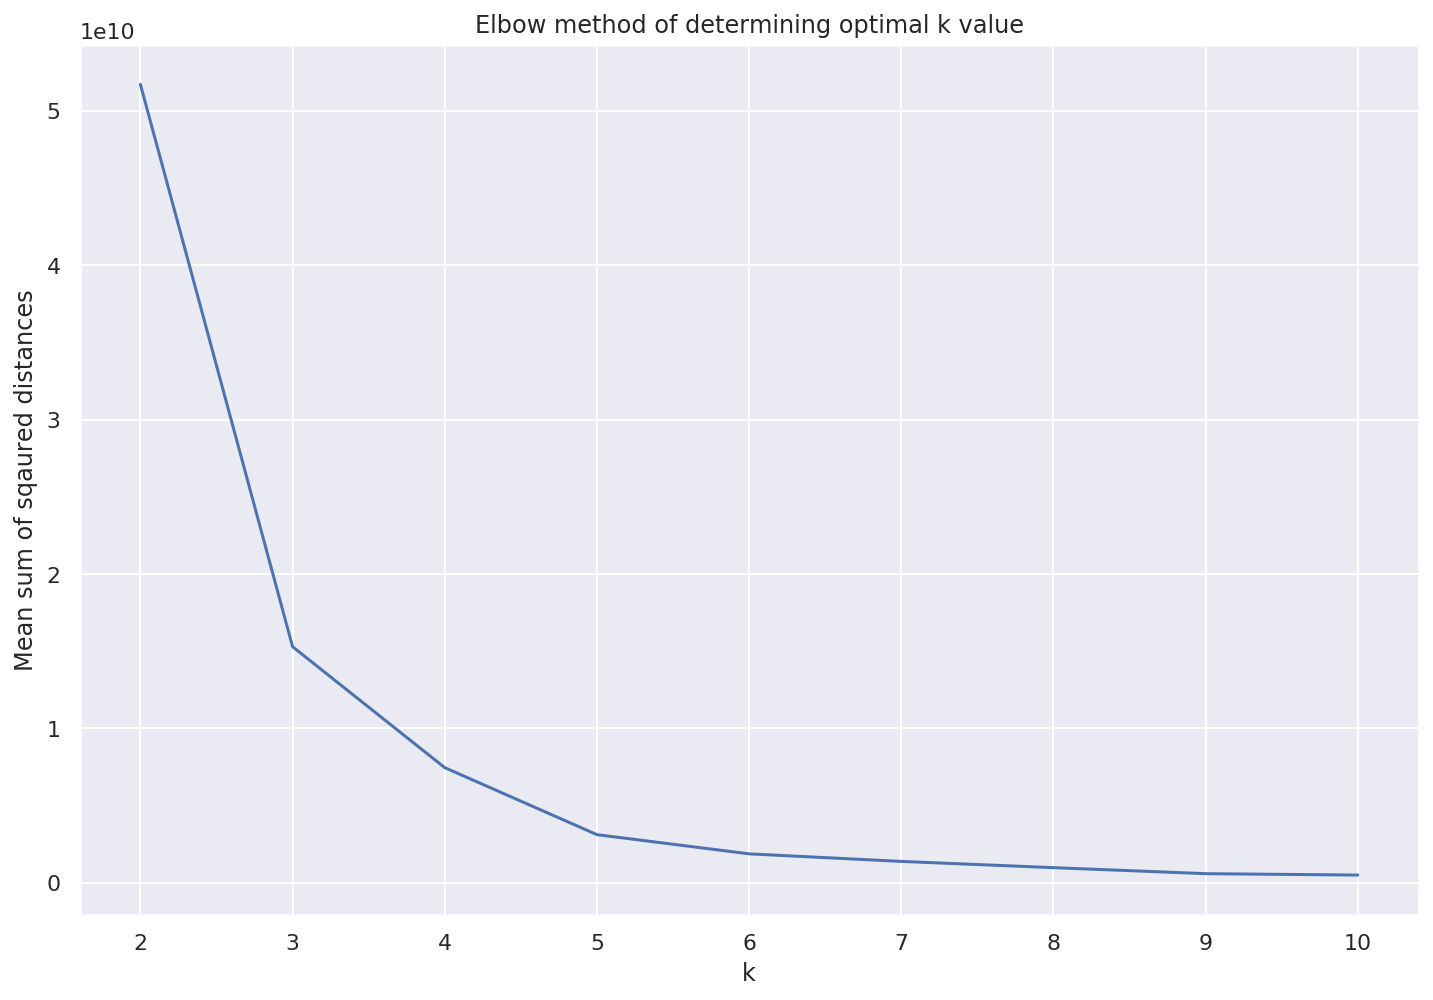

In [15]:
# Plot avg sum of squared distances vs. k
k=range(2,11)
plt.plot(k,ss_list);
plt.xlabel('k')
plt.ylabel('Mean sum of sqaured distances')
plt.title('Elbow method of determining optimal k value');

**Observation:** We select k=4 as the optimal model

In [16]:
ibm_db_conn, conn = connect_to_schema(schema,conn_str)

sql = "SELECT * FROM TPCDS_KM_4_MODEL"
model = pd.read_sql(sql,conn)

sql = "SELECT * FROM TPCDS_KM_4_CLUSTERS"
clusters = pd.read_sql(sql,conn)

print('Model Table:')
display(model)

print('Model Clusters')
display(clusters)
rc = close_connection_to_db(ibm_db_conn, verbose=False)

Model Table:


,MODELCLASS,COMPARISONTYPE,COMPARISONMEASURE,NUMCLUSTERS
0,center-based,distance,euclidean,4


Model Clusters


,CLUSTERID,NAME,DESCRIPTION,SIZE,RELSIZE,WITHINSS
0,3,3,None,12590,0.25180,6.279782e+09
1,4,4,None,10060,0.20120,3.141168e+09
2,1,1,None,9997,0.19994,3.083748e+09
3,2,2,None,17353,0.34706,1.731773e+10


## Apply the K-Means model to the data

In [17]:
# Use the PREDICT_KMEANS procedure to apply the clusters to the data
ibm_db_conn, conn = connect_to_schema(schema,conn_str)

drop_object('TPCDS_KM_4_PREDICT', "TABLE", ibm_db_conn, verbose = True)

sql = "CALL IDAX.PREDICT_KMEANS('model=TPCDS_KM_4, intable=TPCDS_VIEW, outtable=TPCDS_KM_4_PREDICT, id=CLIENT_ID')" 
stmt = ibm_db.exec_immediate(ibm_db_conn, sql)
print("The model has made its predictions")

rc = close_connection_to_db(ibm_db_conn, verbose=False)

Pre-existing TABLE TPCDS_KM_4_PREDICT was not found.
The model has made its predictions


In [18]:
ibm_db_conn, conn = connect_to_schema(schema,conn_str)

sql="select * FROM TPCDS_KM_4_PREDICT;"
predictions = pd.read_sql(sql,conn)

rc = close_connection_to_db(ibm_db_conn, verbose=False)
predictions

,ID,CLUSTER_ID,DISTANCE
0,790,1,259.005160
1,791,2,20.506227
2,792,3,23.614774
3,793,1,259.519575
4,794,1,757.891229
...,...,...,...
49995,49361,4,252.906379
49996,49362,1,742.190520
49997,49363,2,996.687812
49998,49364,3,495.276438


## Visualize the Clusters

In [19]:
ibm_db_conn, conn = connect_to_schema(schema,conn_str)

sql="SELECT a.*, b.cluster_id FROM TPCDS_VIEW as a INNER JOIN TPCDS_KM_4_PREDICT as b ON a.CLIENT_ID=b.ID order by client_id;;"
results = pd.read_sql(sql,conn)

rc = close_connection_to_db(ibm_db_conn, verbose=False)
results

,CLIENT_ID,AGE,GENDER,MARITAL_STATUS,EDUCATION,PURCHASE_ESTIMATE,CREDIT_RATING,NUM_DEPENDANTS,NUM_DEPENDANTS_EMPLOYED,NUM_DEPENDANTS_COUNT,HOUSEHOLD_INCOME,HOUSEHOLD_BUY_POTENTIAL,CLUSTER_ID
0,1,50.0,M,S,College,5000.0,Low Risk,2,1,6,12,501-1000,3
1,2,53.0,M,S,College,8500.0,High Risk,5,2,1,9,>10000,1
2,3,50.0,M,W,2 yr Degree,6500.0,Unknown,1,0,6,20,5001-10000,4
3,4,89.0,M,S,4 yr Degree,2500.0,Unknown,3,1,4,3,0-500,2
4,5,79.0,M,M,Advanced Degree,7000.0,Unknown,1,3,4,7,Unknown,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49996,76.0,F,D,Secondary,7500.0,High Risk,2,1,3,18,Unknown,4
49996,49997,86.0,F,U,Advanced Degree,1000.0,Low Risk,6,4,4,10,Unknown,2
49997,49998,59.0,F,W,Secondary,10000.0,High Risk,5,6,5,2,5001-10000,1
49998,49999,38.0,F,S,4 yr Degree,6000.0,Good,2,0,2,1,>10000,3


In [20]:
# Convert the "CLUSTER_ID" datatype to 'category' for plotting
results['CLUSTER_ID']=results['CLUSTER_ID'].astype('category')

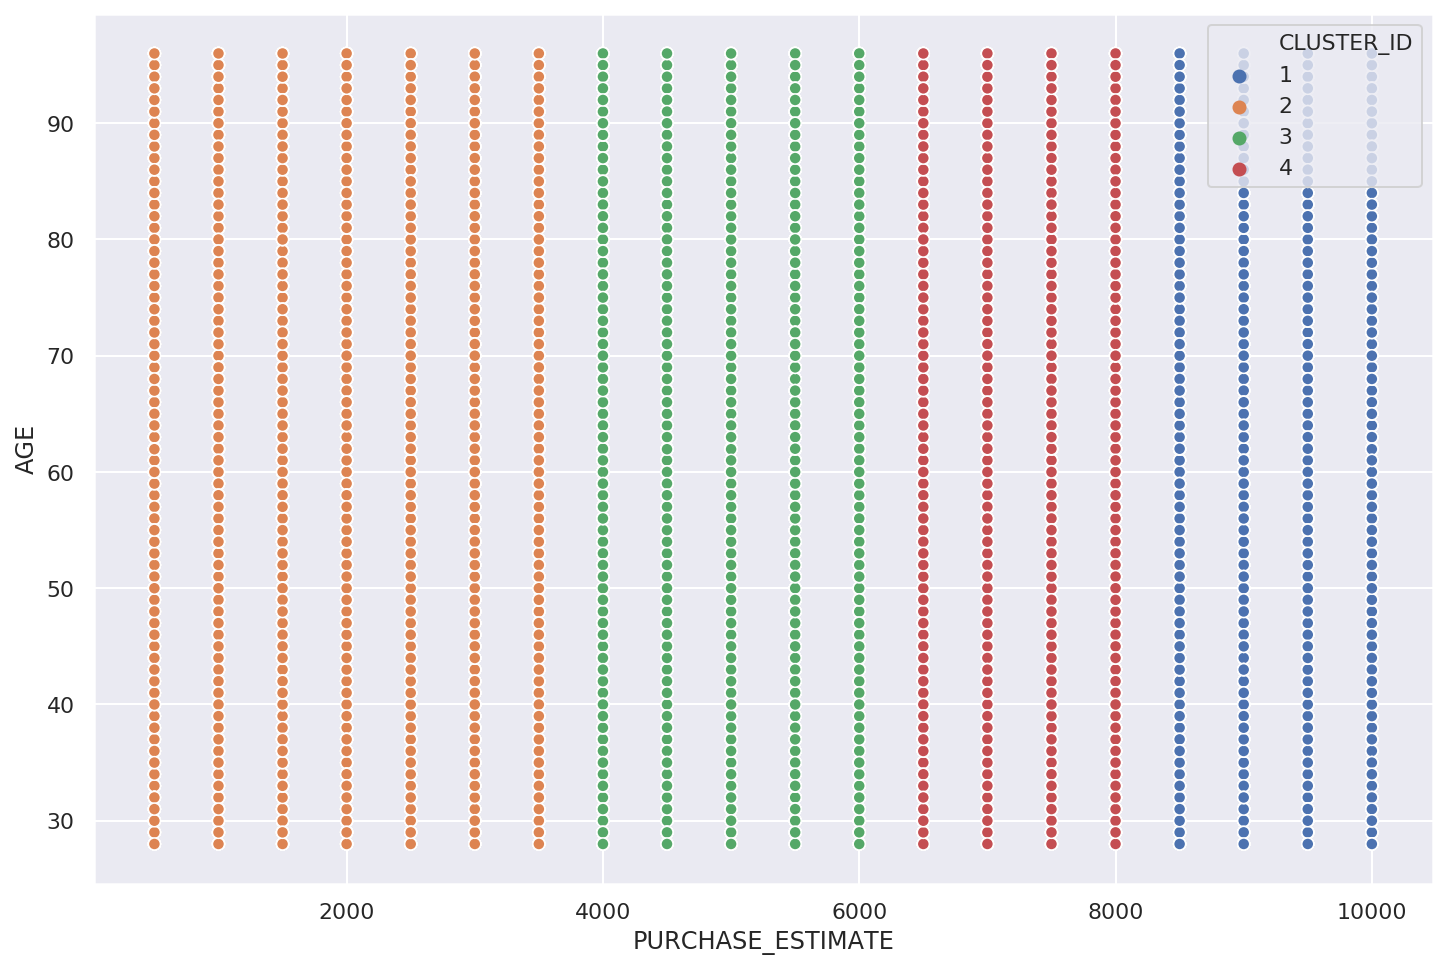

In [22]:
# Plot PURCHASE ESTIMATE VS AGE
plt.figure()
sns.scatterplot( x = 'PURCHASE_ESTIMATE' ,y = 'AGE' , data = results , hue='CLUSTER_ID');
plt.show()